In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from pathlib import Path
import cv2
import json
import pandas as pd
from tqdm.auto import tqdm, trange
from PIL import Image
from sklearn.model_selection import train_test_split
import datetime
import time

from sklearn.metrics import accuracy_score
import lightgbm as lgb

import face_alignment
from skimage import io
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype_float = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [70]:
letters = ['A', 'I', 'U', 'E', 'O', 'N']

In [6]:
workdir = Path('/home/jphacks/LipNet-JP/')

# spk = 's{}'.format(youtube_id)
# txtpath = workdir / 'data/align/output{}word.align'.format(youtube_id)

# lm_path = Path('/home/jphacks/LipNet-JP/data/processed/{0}/{0}.csv'.format(youtube_id))
# croppeddir = Path('/home/jphacks/LipNet-JP/data/processed2/{0}/{0}_aligned_aligned_cropped'.format(youtube_id))
# assert croppeddir.exists()

# datadir = Path('/home/jphacks/LipNet-JP/data')
# # videodir = datadir / 'lip_video'
# # txtdir = datadir / 'align_txt'

In [5]:
inwidth, inheight = 160, 80

# ***Change to use Firebase data***

#### Utils

In [50]:
def _extract_xy(name, xy_dict):  # -> {name_x: Float, name_y: Float}
    return {
        '{}_x'.format(name): xy_dict['x'],
        '{}_y'.format(name): xy_dict['y'],
    }

def _extract_xy_list(name, xy_dict_list):  # -> {name_x_0: Float, name_y_0: Float}
    tmp_list = [_extract_xy('{}_{}'.format(name, i), xy_dict) 
                 for i, xy_dict in enumerate(xy_dict_list)]
    return {
        k: v
        for d in tmp_list
        for k, v in d.items()
    }

def extract_to_df(data):
    res = {
        # {'centerPoint': {'x': 0.4855373203754425, 'y': 0.30535265803337097},
        **_extract_xy('centerPoint', data['centerPoint']),
        #  'faceContour': [{'x': 0.8791602253913879, 'y': 0.7177956700325012},
        **_extract_xy_list('faceContour', data['faceContour']),
        #  'innerHeight': 0.06307950615882874,
        'innerHeight': data['innerHeight'],
        #  'innerPoints': [{'x': 0.4265343248844147, 'y': 0.33877941966056824},
        **_extract_xy_list('innerPoints', data['innerPoints']),
        #  'innerWidth': 0.1182754635810852,
        'innerWidth': data['innerWidth'],
        #  'leftEye': [{'x': 0.236593097448349, 'y': 0.7194131016731262},
        **_extract_xy_list('leftEye', data['leftEye']),
        #  'leftEyebrow': [{'x': 0.19079166650772095, 'y': 0.844763457775116},
        **_extract_xy_list('leftEyebrow', data['leftEyebrow']),
        #  'leftPupil': [{'x': 0.3044869601726532, 'y': 0.7288480997085571}],
        **_extract_xy_list('leftPupil', data['leftPupil']),
        #  'median': [{'x': 0.49469760060310364, 'y': 0.7412483096122742},
        **_extract_xy_list('median', data['median']),
        #  'nose': [{'x': 0.49308109283447266, 'y': 0.6676555275917053},
        **_extract_xy_list('nose', data['nose']),
        #  'noseCrest': [{'x': 0.49469760060310364, 'y': 0.7412483096122742},
        **_extract_xy_list('noseCrest', data['noseCrest']),
        #  'outerHeight': 0.17683832347393036,
        'outerHeight': data['outerHeight'],
        #  'outerPoints': [{'x': 0.3686089813709259, 'y': 0.34686654806137085},
        **_extract_xy_list('outerPoints', data['outerPoints']),
        #  'outerWidth': 0.2863936424255371,
        'outerWidth': data['outerWidth'],
        #  'rightEye': [{'x': 0.7579210996627808, 'y': 0.7264219522476196},
        **_extract_xy_list('rightEye', data['rightEye']),
        #  'rightEyebrow': [{'x': 0.8209654688835144, 'y': 0.8535244464874268},
        **_extract_xy_list('rightEyebrow', data['rightEyebrow']),
        #  'rightPupil': [{'x': 0.681405782699585, 'y': 0.7350481748580933}],
        **_extract_xy_list('rightPupil', data['rightPupil']),
        #  'timestamp': 1572419402.812715,
        'timestamp': data['timestamp'],
        #  'uuid': '0FA48F40-AB4D-43DC-849A-D5AB158B52CF'}
        # Should not use
    }
    return res

# list(extract_to_df(lm_xy_data).keys())

['centerPoint_x',
 'centerPoint_y',
 'faceContour_0_x',
 'faceContour_0_y',
 'faceContour_1_x',
 'faceContour_1_y',
 'faceContour_2_x',
 'faceContour_2_y',
 'faceContour_3_x',
 'faceContour_3_y',
 'faceContour_4_x',
 'faceContour_4_y',
 'faceContour_5_x',
 'faceContour_5_y',
 'faceContour_6_x',
 'faceContour_6_y',
 'faceContour_7_x',
 'faceContour_7_y',
 'faceContour_8_x',
 'faceContour_8_y',
 'faceContour_9_x',
 'faceContour_9_y',
 'faceContour_10_x',
 'faceContour_10_y',
 'faceContour_11_x',
 'faceContour_11_y',
 'faceContour_12_x',
 'faceContour_12_y',
 'faceContour_13_x',
 'faceContour_13_y',
 'faceContour_14_x',
 'faceContour_14_y',
 'faceContour_15_x',
 'faceContour_15_y',
 'faceContour_16_x',
 'faceContour_16_y',
 'innerHeight',
 'innerPoints_0_x',
 'innerPoints_0_y',
 'innerPoints_1_x',
 'innerPoints_1_y',
 'innerPoints_2_x',
 'innerPoints_2_y',
 'innerPoints_3_x',
 'innerPoints_3_y',
 'innerPoints_4_x',
 'innerPoints_4_y',
 'innerPoints_5_x',
 'innerPoints_5_y',
 'innerWidth',

In [14]:
firelmpath = '/home/jphacks/LipNet-JP/data/firebase/jphacks-export.json'
with open(firelmpath) as f:
    firelmdict = json.load(f)

In [52]:
firecolumns = ['centerPoint_x', 'centerPoint_y', 'faceContour_0_x', 'faceContour_0_y', 'faceContour_1_x', 'faceContour_1_y', 'faceContour_2_x', 'faceContour_2_y', 'faceContour_3_x', 'faceContour_3_y', 'faceContour_4_x', 'faceContour_4_y', 'faceContour_5_x', 'faceContour_5_y', 'faceContour_6_x', 'faceContour_6_y', 'faceContour_7_x', 'faceContour_7_y', 'faceContour_8_x', 'faceContour_8_y', 'faceContour_9_x', 'faceContour_9_y', 'faceContour_10_x', 'faceContour_10_y', 'faceContour_11_x', 'faceContour_11_y', 'faceContour_12_x', 'faceContour_12_y', 'faceContour_13_x', 'faceContour_13_y', 'faceContour_14_x', 'faceContour_14_y', 'faceContour_15_x', 'faceContour_15_y', 'faceContour_16_x', 'faceContour_16_y', 'innerHeight', 'innerPoints_0_x', 'innerPoints_0_y', 'innerPoints_1_x', 'innerPoints_1_y', 'innerPoints_2_x', 'innerPoints_2_y', 'innerPoints_3_x', 'innerPoints_3_y', 'innerPoints_4_x', 'innerPoints_4_y', 'innerPoints_5_x', 'innerPoints_5_y', 'innerWidth', 'leftEye_0_x', 'leftEye_0_y', 'leftEye_1_x', 'leftEye_1_y', 'leftEye_2_x', 'leftEye_2_y', 'leftEye_3_x', 'leftEye_3_y', 'leftEye_4_x', 'leftEye_4_y', 'leftEye_5_x', 'leftEye_5_y', 'leftEyebrow_0_x', 'leftEyebrow_0_y', 'leftEyebrow_1_x', 'leftEyebrow_1_y', 'leftEyebrow_2_x', 'leftEyebrow_2_y', 'leftEyebrow_3_x', 'leftEyebrow_3_y', 'leftEyebrow_4_x', 'leftEyebrow_4_y', 'leftEyebrow_5_x', 'leftEyebrow_5_y', 'leftPupil_0_x', 'leftPupil_0_y', 'median_0_x', 'median_0_y', 'median_1_x', 'median_1_y', 'median_2_x', 'median_2_y', 'median_3_x', 'median_3_y', 'median_4_x', 'median_4_y', 'median_5_x', 'median_5_y', 'median_6_x', 'median_6_y', 'median_7_x', 'median_7_y', 'median_8_x', 'median_8_y', 'median_9_x', 'median_9_y', 'nose_0_x', 'nose_0_y', 'nose_1_x', 'nose_1_y', 'nose_2_x', 'nose_2_y', 'nose_3_x', 'nose_3_y', 'nose_4_x', 'nose_4_y', 'nose_5_x', 'nose_5_y', 'nose_6_x', 'nose_6_y', 'nose_7_x', 'nose_7_y', 'noseCrest_0_x', 'noseCrest_0_y', 'noseCrest_1_x', 'noseCrest_1_y', 'noseCrest_2_x', 'noseCrest_2_y', 'noseCrest_3_x', 'noseCrest_3_y', 'noseCrest_4_x', 'noseCrest_4_y', 'noseCrest_5_x', 'noseCrest_5_y', 'outerHeight', 'outerPoints_0_x', 'outerPoints_0_y', 'outerPoints_1_x', 'outerPoints_1_y', 'outerPoints_2_x', 'outerPoints_2_y', 'outerPoints_3_x', 'outerPoints_3_y', 'outerPoints_4_x', 'outerPoints_4_y', 'outerPoints_5_x', 'outerPoints_5_y', 'outerPoints_6_x', 'outerPoints_6_y', 'outerPoints_7_x', 'outerPoints_7_y', 'outerPoints_8_x', 'outerPoints_8_y', 'outerPoints_9_x', 'outerPoints_9_y', 'outerPoints_10_x', 'outerPoints_10_y', 'outerPoints_11_x', 'outerPoints_11_y', 'outerPoints_12_x', 'outerPoints_12_y', 'outerPoints_13_x', 'outerPoints_13_y', 'outerWidth', 'rightEye_0_x', 'rightEye_0_y', 'rightEye_1_x', 'rightEye_1_y', 'rightEye_2_x', 'rightEye_2_y', 'rightEye_3_x', 'rightEye_3_y', 'rightEye_4_x', 'rightEye_4_y', 'rightEye_5_x', 'rightEye_5_y', 'rightEyebrow_0_x', 'rightEyebrow_0_y', 'rightEyebrow_1_x', 'rightEyebrow_1_y', 'rightEyebrow_2_x', 'rightEyebrow_2_y', 'rightEyebrow_3_x', 'rightEyebrow_3_y', 'rightEyebrow_4_x', 'rightEyebrow_4_y', 'rightEyebrow_5_x', 'rightEyebrow_5_y', 'rightPupil_0_x', 'rightPupil_0_y', 'timestamp']

In [54]:
fire_df = pd.DataFrame(columns=firecolumns + ['target'])

In [77]:
for target_i, target in enumerate(['a', 'i', 'u', 'e', 'o', 'n']):
    for user, frame_data in firelmdict['vowel_log'][target].items():
        print('Extracting for user {}'.format(user))
        for frame_name, lm_xy_data in frame_data.items():
            res_row = {**extract_to_df(lm_xy_data), 'target': int(target_i)}
            fire_df = fire_df.append(res_row, ignore_index=True)

fire_df

Extracting for user 0FA48F40-AB4D-43DC-849A-D5AB158B52CF
Extracting for user 2009FC6B-C143-4F58-AFB9-464D2D42C4AF
Extracting for user 278D67D3-5F9E-462E-8D6E-F11922E25A46
Extracting for user 3C41CD0A-6F31-4628-A497-CA8212D95C39
Extracting for user 457808A0-787F-44D6-A359-FA804F904B54
Extracting for user 472534F2-D288-4113-9CB8-5F862C75446E
Extracting for user 665215FF-A4F4-49C8-91BE-CE7F97B0706C
Extracting for user 7A4B833F-ECFA-4DDD-A960-AF5D87A807DF
Extracting for user 7C989A26-F36E-4BAD-AA62-B306E55D6098
Extracting for user 8461733D-0EA6-46EB-8878-DCBCD0F54D9B
Extracting for user 9015141A-9A47-4F4A-956F-BF4FCFEABF5B
Extracting for user D6FF7BC5-036A-4BC9-A359-3FCA8AAD10F5
Extracting for user FBE74105-AB1A-4007-A952-BCAA68DCE627
Extracting for user 0FA48F40-AB4D-43DC-849A-D5AB158B52CF
Extracting for user 278D67D3-5F9E-462E-8D6E-F11922E25A46
Extracting for user 3C41CD0A-6F31-4628-A497-CA8212D95C39
Extracting for user 457808A0-787F-44D6-A359-FA804F904B54
Extracting for user 472534F2-D2

,centerPoint_x,centerPoint_y,faceContour_0_x,faceContour_0_y,faceContour_1_x,faceContour_1_y,faceContour_2_x,faceContour_2_y,faceContour_3_x,faceContour_3_y,...,rightEyebrow_3_x,rightEyebrow_3_y,rightEyebrow_4_x,rightEyebrow_4_y,rightEyebrow_5_x,rightEyebrow_5_y,rightPupil_0_x,rightPupil_0_y,timestamp,target
0,0.485537,0.305353,0.879160,0.717796,0.882393,0.609967,0.870539,0.501600,0.850063,0.394311,...,0.591958,0.827915,0.704576,0.852446,0.817732,0.829802,0.681406,0.735048,1.572419e+09,0.0
1,0.492028,0.316491,0.875982,0.720750,0.879238,0.615138,0.867842,0.508711,0.847219,0.403913,...,0.586728,0.823240,0.699065,0.851340,0.813573,0.832335,0.678443,0.726180,1.572419e+09,1.0
2,0.492238,0.291980,0.884907,0.723179,0.886491,0.618814,0.872232,0.513392,0.849522,0.409291,...,0.590735,0.825431,0.704813,0.854759,0.821003,0.839566,0.679990,0.725029,1.572419e+09,2.0
3,0.479012,0.295640,0.892816,0.727926,0.896628,0.616246,0.884649,0.503203,0.863415,0.392067,...,0.588452,0.841922,0.701160,0.865620,0.814956,0.847506,0.681014,0.736098,1.572419e+09,3.0
4,0.494165,0.248060,0.896677,0.715340,0.899596,0.603485,0.885585,0.490461,0.860483,0.380067,...,0.589028,0.830554,0.710453,0.856108,0.830711,0.831430,0.688270,0.731111,1.572419e+09,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6801,0.497726,0.292274,0.863677,0.700749,0.863677,0.591884,0.845900,0.483632,0.815864,0.376913,...,0.629517,0.853467,0.738628,0.855154,0.840383,0.816974,0.700623,0.729575,1.572413e+09,5.0
6802,0.505779,0.293632,0.864407,0.696944,0.864407,0.590185,0.846624,0.484019,0.816393,0.379632,...,0.636189,0.846851,0.740517,0.848779,0.838918,0.813192,0.703173,0.725116,1.572413e+09,5.0
6803,0.504791,0.297639,0.862131,0.709389,0.863957,0.600970,0.847521,0.492551,0.818301,0.385959,...,0.638108,0.860902,0.741597,0.864404,0.838998,0.830295,0.701419,0.734971,1.572413e+09,5.0
6804,0.506292,0.295945,0.867313,0.704027,0.868553,0.595412,0.851805,0.487107,0.822030,0.380354,...,0.635316,0.860122,0.742630,0.862295,0.843741,0.824745,0.704791,0.733508,1.572413e+09,5.0


# Use Python face-landmark package

In [9]:
import face_alignment
from skimage import io

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)


In [10]:
youtube_id = 1
faceimgdir = Path('/home/jphacks/LipNet-JP/data/processed/{0}/{0}_aligned'.format(youtube_id))
print(list(faceimgdir.iterdir())[0])


/home/jphacks/LipNet-JP/data/processed/1/1_aligned/frame_det_00_002946.bmp


In [ ]:
input = io.imread(list(faceimgdir.iterdir())[0])
preds = fa.get_landmarks(input)

preds = preds[0]
sns.scatterplot(x=[p[0] for p in preds], y=[p[1] for p in preds])

## Load Data

In [7]:
lm_df_list = []

for youtube_id in tqdm(range(1, 2+1)):  # max is 6 but it is too slow
    aligned_lm_path = Path('/home/jphacks/LipNet-JP/data/processed2/{0}/{0}_aligned.csv'.format(youtube_id))
    aligned_lm_df = pd.read_csv(str(aligned_lm_path))
    aligned_lm_df['timestamp'] = (aligned_lm_df['frame'] - 1) * (1/30)

    # Imgpathをdfに追加する
    aligned_lm_df['imgpath'] = aligned_lm_df.apply(
        lambda r: '/home/jphacks/LipNet-JP/data/processed2/{0}/{0}_aligned_aligned_cropped/frame_det_00_{1:06d}.bmp'.format(
            youtube_id, int(r.frame)), axis=1)

    txtpath = workdir / 'data/align/output{}word.align'.format(youtube_id)
    with open(txtpath, 'r') as f:
        txt = json.load(f)

    aligned_lm_df['target'] = -1

    for word in txt:
        for c in word:
            aligned_lm_df.loc[(aligned_lm_df.timestamp >= c['start']) & (aligned_lm_df.timestamp < c['end']), 
                              'target'] \
            = letters.index(c['word'].upper())
    lm_df_list.append(aligned_lm_df)

lm_df = pd.concat(lm_df_list)

In [ ]:
## 話していないときのデータを削除
lm_df = lm_df[lm_df['target'] != -1]
lm_df

# ResNet

### Util

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Data Import

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(152),
    transforms.CenterCrop(152),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Load

In [ ]:
imglist = []
targetlist = []
_lett_counter = {l: 0 for l in letters}
for idx, row in tqdm(lm_df.iterrows()):
    if row.target < 0:
        continue
    imgpath = row.imgpath
    img = Image.open(str(imgpath))
    input_tensor = preprocess(img)
    size = np.asarray(img).shape
    if size != (inheight, inwidth, 3):
        continue
    # img = np.moveaxis(img, 2, 0)  # (80, 160, 3) -> (3, 80, 160)
    imglist.append(input_tensor)
    targetlist.append(int(row.target))
    _lett_counter[letters[int(row.target)]] += 1

## Dataset

In [ ]:
class LipDataset(Dataset):
    def __init__(self, imglist, targetlist, idxlist):
        self.imglist = imglist
        self.targetlist = targetlist
        self.idxlist = idxlist
    
    def __len__(self):
        return len(self.idxlist)
    
    def __getitem__(self, idx):
        return (self.imglist[self.idxlist[idx]], self.targetlist[self.idxlist[idx]])
    
    def _to_list(self):
        return [self[i] for i in range(len(self))]

In [ ]:
train_idxlist, test_idxlist = train_test_split(list(range(len(imglist))), test_size=.2, shuffle=True)
train_idxlist, validate_idxlist = train_test_split(train_idxlist, test_size=.2, shuffle=True)

print(len(train_idxlist), len(validate_idxlist), len(test_idxlist))

In [ ]:
train_lipdataset = LipDataset(imglist, targetlist, train_idxlist)
validate_lipdataset = LipDataset(imglist, targetlist, validate_idxlist)
test_lipdataset = LipDataset(imglist, targetlist, test_idxlist)

In [ ]:
BATCH_SIZE = 18

In [ ]:
trainloader = torch.utils.data.DataLoader(train_lipdataset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
validateloader = torch.utils.data.DataLoader(validate_lipdataset, batch_size=1,
                                         shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_lipdataset, batch_size=1,
                                         shuffle=False, num_workers=2)

## Model

In [ ]:
# net = torchvision.models.resnet34(pretrained=True, num_classes=6).to(device)
net = torchvision.models.resnet34(pretrained=False, num_classes=6).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Train

In [ ]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch_idx, (data, target) in tqdm(enumerate(iterator)):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = net(data)
        
        loss = criterion(output, target)
        _, predicted = torch.max(output, 1)
        acc = (predicted == target.to(device)).sum()
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item() / BATCH_SIZE
        epoch_acc += acc.item() / BATCH_SIZE
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch_idx, (data, target) in tqdm(enumerate(iterator)):
            
            data, target = data.to(device), target.to(device)
                        
            output = model(data.type(dtype_float))
            
            loss = criterion(output, target)
            
            _, predicted = torch.max(output.data, 1)
            
            acc = (predicted == target.to(device)).sum()
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(net, trainloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(net, validateloader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(net.state_dict(), 'tut5-model_bagging.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#     print(train_loss, train_acc)
#     print(valid_loss, valid_acc)
    print(f'\tTrain Loss: {float(train_loss):.3f} | Train Acc: {float(train_acc*100):.2f}%')
    print(f'\t Val. Loss: {float(valid_loss):.3f} |  Val. Acc: {float(valid_acc*100):.2f}%')

## Test

In [ ]:
def test(model, iterator, optimizer, criterion):
    model.eval()
    class_correct = [0.] * len(letters)
    class_total = [0.] * len(letters)
    with torch.no_grad():
        for data in iterator:
            images, labels = data
            outputs = net(images.type(dtype_float))
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels.to(device)).squeeze()
            class_correct[labels.item()] += c.item() * 1
            class_total[labels.item()] += 1

    for i, l in enumerate(letters):
        print('Accuracy of    {}: {:.4f} ({:4d}/{:4d})'.format(l, class_correct[i]/class_total[i] if class_total[i] > 0 else 0, int(class_correct[i]), int(class_total[i])))

In [ ]:
test(net, testloader, optimizer, criterion)

## Load

In [ ]:
dtype_float = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(152),
    transforms.CenterCrop(152),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
model = torchvision.models.resnet34(pretrained=False, num_classes=6).to(device)
model.load_state_dict(torch.load("tut5-model.pt"))

predict_label_dict = {i: 0 for i in range(len(letters))}
for i, imgpath in enumerate(croppeddir.iterdir()):
    img = Image.open(str(imgpath))
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)

    outputs = model(input_batch.type(dtype_float))
    _, predicted = torch.max(outputs, 1)
    predict_label = predicted.squeeze().item()
    predict_label_dict[predict_label] += 1
    if i > 100:
        break
predict_label_dict

# Bagging using ResNet

## Preprocess Data

### Split

In [62]:
aligned_lm_df = fire_df

In [63]:
train_df, test_df = train_test_split(aligned_lm_df, test_size=.2, shuffle=True)

In [64]:
train_x = train_df[(set(train_df.columns) - {'target'})].values
train_y = train_df.target.values

test_x = test_df[(set(test_df.columns) - {'target'})].values
test_y = test_df.target.values

### Add ResNet result to data

### Data -> Train Test Dataset

# LGBM

In [65]:
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [66]:
model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
model.fit(train_x, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [67]:
accuracy_score(model.predict(train_x), train_y)

1.0

In [68]:
accuracy_score(model.predict(test_x), test_y)

0.9853372434017595

In [72]:
pred = model.predict(test_x)

class_correct = [0] * len(letters)
class_total = [0] * len(letters)

for p, a in zip(pred, test_y):
    a = int(a)
    class_total[a] += 1
    if p == a:
        class_correct[a] += 1

for i, l in enumerate(letters):
    print('Accuracy of    {}: {:.4f} ({:4d}/{:4d})'.format(l, class_correct[i]/class_total[i], class_correct[i], class_total[i]))

Accuracy of    A: 1.0000 ( 154/ 154)
Accuracy of    I: 0.9748 ( 116/ 119)
Accuracy of    U: 1.0000 ( 109/ 109)
Accuracy of    E: 0.9804 ( 100/ 102)
Accuracy of    O: 0.9798 (  97/  99)
Accuracy of    N: 0.9697 (  96/  99)


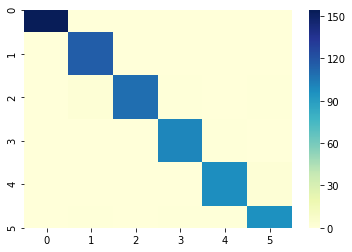

In [76]:
confusion_matrix = np.zeros([len(letters), len(letters)])
for p, a in zip(pred, test_y):
    a = int(a)
    p = int(p)
    confusion_matrix[p, a] += 1
    
sns.heatmap(confusion_matrix, cmap="YlGnBu")

### LGBMでセーブ・ロード
https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

In [78]:
model_fname = 'lgbm_fire.model'

In [79]:
model_outpath = Path('/home/jphacks/LipNet-JP/model_checkpoints')
model_outpath.mkdir(exist_ok=True)

model.booster_.save_model(str(model_outpath / model_fname))

In [80]:
bst = lgb.Booster(model_file=str(model_outpath / model_fname))

In [82]:
import lightgbm as lgb
from pathlib import Path

model_outpath = Path('/home/jphacks/LipNet-JP/model_checkpoints')
bst = lgb.Booster(model_file=str(model_outpath / model_fname))

pred = bst.predict(test_x)
pred = list(np.argmax(pred, axis=1))

class_correct = [0] * len(letters)
class_total = [0] * len(letters)
for p, a in zip(pred, test_y):
    p = int(p)
    a = int(a)
    class_total[a] += 1
    if p == a:
        class_correct[a] += 1
for i, l in enumerate(letters):
    print('Accuracy of    {}: {:.4f} ({:4d}/{:4d})'.format(l, class_correct[i]/class_total[i], class_correct[i], class_total[i]))

Accuracy of    A: 1.0000 ( 154/ 154)
Accuracy of    I: 0.9748 ( 116/ 119)
Accuracy of    U: 1.0000 ( 109/ 109)
Accuracy of    E: 0.9804 ( 100/ 102)
Accuracy of    O: 0.9798 (  97/  99)
Accuracy of    N: 0.9697 (  96/  99)
